In [1]:
#Install Required Libraries
!pip install tensorflow matplotlib opencv-python
!pip install segmentation-models==1.0.1

In [2]:
#Import Libraries
import os, glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import segmentation_models as sm

#Set framework for segmentation_models
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [3]:
#Configuration
BACKBONE = 'efficientnetb0'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
NUM_CLASSES = 1  # Binary segmentation
LR = 0.0001
EPOCHS = 5

In [5]:
# Dataset paths
TRAIN_IMG_DIR = "DATASET/dataset/train/images"
TRAIN_MASK_DIR = "DATASET/dataset/train/masks"
VAL_IMG_DIR = "DATASET/dataset/validation/images"
VAL_MASK_DIR = "DATASET/dataset/validation/masks"
TEST_IMG_DIR = "DATASET/dataset/test/images"
TEST_MASK_DIR = "DATASET/dataset/test/masks"

In [6]:
print("Training Images :", len(glob.glob(os.path.join(TRAIN_IMG_DIR, "*.png"))))
print("Training Masks  :", len(glob.glob(os.path.join(TRAIN_MASK_DIR, "*.png"))))
print("Validation Images :", len(glob.glob(os.path.join(VAL_IMG_DIR, "*.png"))))
print("Validation Masks  :", len(glob.glob(os.path.join(VAL_MASK_DIR, "*.png"))))
print("Test Images :", len(glob.glob(os.path.join(TEST_IMG_DIR, "*.png"))))
print("Test Masks  :", len(glob.glob(os.path.join(TEST_MASK_DIR, "*.png"))))

Training Images : 1385
Training Masks  : 1385
Validation Images : 396
Validation Masks  : 396
Test Images : 199
Test Masks  : 199


In [7]:
import tensorflow as tf
import numpy as np
import cv2
# Function: Load Image & Mask
def load_image_mask(image_path, mask_path, image_size=IMAGE_SIZE):
    # Load grayscale image
    image = cv2.imread(image_path.decode(), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, image_size)
    # Convert to 3 channels
    image = np.stack((image,)*3, axis=-1)
    image = image.astype(np.float32) / 255.0

    # Load mask
    mask = cv2.imread(mask_path.decode(), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
    # Binarize mask
    mask = (mask > 127).astype(np.float32)
    # Add channel dimension
    mask = np.expand_dims(mask, axis=-1)

    return image, mask

# TensorFlow Wrapper
def tf_load_wrapper(image_path, mask_path):
    image, mask = tf.numpy_function(
        load_image_mask, [image_path, mask_path], [tf.float32, tf.float32]
    )
    # Set static shapes
    image.set_shape([*IMAGE_SIZE, 3])
    mask.set_shape([*IMAGE_SIZE, 1])
    return image, mask


In [8]:
import tensorflow as tf
import glob
import os
#Data Augmentation
def augment(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random rotation
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    # Random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, mask

# Dataset Creation Function
def create_dataset(images_dir, masks_dir, batch_size=BATCH_SIZE, repeat=False, augment_data=False):
    # Get sorted file lists
    image_files = sorted(glob.glob(os.path.join(images_dir, "*.png")))
    mask_files  = sorted(glob.glob(os.path.join(masks_dir, "*.png")))

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(tf_load_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation if requested
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset
# Create Train / Val / Test Datasets
train_dataset = create_dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, batch_size=BATCH_SIZE, repeat=True, augment_data=True)
val_dataset   = create_dataset(VAL_IMG_DIR, VAL_MASK_DIR, batch_size=BATCH_SIZE)
test_dataset  = create_dataset(TEST_IMG_DIR, TEST_MASK_DIR, batch_size=BATCH_SIZE)

# Check batch shapes
for images, masks in train_dataset.take(1):
    print("Batch images shape:", images.shape)  # Should be (BATCH_SIZE, 256,256,3)
    print("Batch masks shape :", masks.shape)   # Should be (BATCH_SIZE, 256,256,1)


Batch images shape: (8, 256, 256, 3)
Batch masks shape : (8, 256, 256, 1)


Images shape: (8, 256, 256, 3)
Masks shape : (8, 256, 256, 1)
Images min/max: 0.0037554055 0.81426597
Masks unique values: [0. 1.]


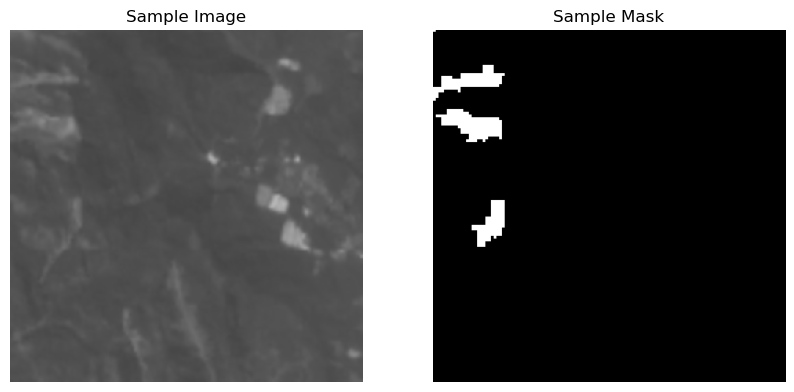

Image dtype: <dtype: 'float32'>
Mask dtype: <dtype: 'float32'>


In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

for images, masks in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Masks shape :", masks.shape)
    print("Images min/max:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())
    print("Masks unique values:", np.unique(masks.numpy()))

    # Plot a sample
    plt.figure(figsize=(10, 5))

    # Show image (take first in batch)
    plt.subplot(1, 2, 1)
    plt.title("Sample Image")
    plt.imshow(images[0])
    plt.axis('off')

    # Show mask safely
    plt.subplot(1, 2, 2)
    plt.title("Sample Mask")
    mask_sample = tf.squeeze(masks[0])  # Remove channel dimension if exists
    plt.imshow(mask_sample, cmap='gray')
    plt.axis('off')

    plt.show()

print("Image dtype:", images.dtype)
print("Mask dtype:", masks.dtype)


In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 1  # Binary segmentation
IMAGE_SIZE = (256, 256)

def build_unet(input_shape=(256,256,3), num_classes=NUM_CLASSES):
    # Encoder: EfficientNetB0
    base_model = EfficientNetB0(include_top=False, weights=None, input_shape=input_shape)

    # Skip connections for U-Net
    skips = [
        base_model.get_layer("block2a_expand_activation").output,  # 128x128
        base_model.get_layer("block3a_expand_activation").output,  # 64x64
        base_model.get_layer("block4a_expand_activation").output,  # 32x32
        base_model.get_layer("block6a_expand_activation").output   # 16x16
    ]

    # Bottleneck
    x = base_model.output
    # Decoder: Upsampling + Skip Connections

    # Level 4: 8x8 -> 16x16
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skips[3]])

    # Level 3: 16x16 -> 32x32
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skips[2]])

    # Level 2: 32x32 -> 64x64
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skips[1]])

    # Level 1: 64x64 -> 128x128
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skips[0]])

    # Output Level: 128x128 -> 256x256
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)

    # Final layer: 1x1 conv for 1 class
    output = layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x)

    # Build model
    model = models.Model(inputs=base_model.input, outputs=output)
    return model


In [11]:
# Build U-Net Model
model = build_unet(input_shape=(*IMAGE_SIZE, 3))
# Show Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_

 Total params: 11,974,564 (45.68 MB)

 Trainable params: 11,932,541 (45.52 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [14]:
import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loss Function
# Dice Loss: optimizes overlap (F1-score proxy) → great for imbalanced datasets
# Binary Cross-Entropy (BCE): standard pixel-wise loss
dice_loss = sm.losses.DiceLoss()
bce_loss = sm.losses.BinaryCELoss()  
combined_loss = dice_loss + bce_loss

#Metrics to Monitor
# Monitor IoU, F1-score, Precision, Recall, and Accuracy
metrics = [
    sm.metrics.IOUScore(threshold=0.5),     # Intersection over Union
    sm.metrics.FScore(threshold=0.5),       # F1-score
    sm.metrics.Precision(threshold=0.5),    # Precision
    sm.metrics.Recall(threshold=0.5),       # Recall
    'accuracy'                               # Overall pixel-wise accuracy
]
#Callbacks
callbacks = [
    # Save best weights based on validation F1-score
    ModelCheckpoint(
        'best_model.weights.keras', 
        monitor='val_f1-score', 
        save_best_only=True, 
        save_weights_only=True, 
        verbose=1
    ),
    # Stop training if validation loss does not improve for 10 epochs
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
]


In [15]:
from tensorflow.keras.optimizers import Adam

# Learning rate for fine-tuning
LR = 1e-4  # Lower LR helps stabilize training for segmentation tasks

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss=combined_loss,   # Dice + BCE loss
    metrics=metrics       # IoU, F1-score, Precision, Recall, Accuracy
)

print("Model compiled successfully with combined loss and metrics for precision/recall.")


Model compiled successfully with combined loss and metrics for precision/recall.


In [23]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import math
import os
import glob

# Training Parameters
EPOCHS = 5
BATCH_SIZE = 8

# Calculate steps per epoch
STEPS_PER_EPOCH = math.ceil(len(glob.glob(os.path.join(TRAIN_IMG_DIR, "*.png"))) / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(len(glob.glob(os.path.join(VAL_IMG_DIR, "*.png"))) / BATCH_SIZE)

# Option
import numpy as np

# Define custom F1 score metric
def f1_score_metric(y_true, y_pred):
    # Cast inputs to float
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Apply threshold to get binary predictions
    y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)
    
    # Calculate true positives, false positives, false negatives
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    
    # Calculate precision and recall
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

# Define custom IoU metric
def iou_metric(y_true, y_pred):
    # Cast inputs to float
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Apply threshold to get binary predictions
    y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    # Calculate IoU
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

# Loss Function (Focal Tversky Loss)
def focal_tversky_loss(alpha=0.7, beta=0.3, gamma=0.75):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        TP = tf.reduce_sum(y_true * y_pred)
        FP = tf.reduce_sum((1 - y_true) * y_pred)
        FN = tf.reduce_sum(y_true * (1 - y_pred))
        Tversky = (TP + 1e-6) / (TP + alpha * FP + beta * FN + 1e-6)
        return tf.pow((1 - Tversky), gamma)
    return loss

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='val_f1_score_metric', 
    mode='max',          # maximize F1-score
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_score_metric',  
    factor=0.5,
    patience=2,
    verbose=1,
    mode='max',
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_f1_score_metric',  
    patience=5,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

callbacks = [checkpoint, reduce_lr, early_stop]

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_tversky_loss(alpha=0.7, beta=0.3, gamma=0.75),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), f1_score_metric, iou_metric]
)

# Start Training
history = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    # class_weight=class_weights  
)

Epoch 1/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9589 - f1_score_metric: 0.5159 - iou_metric: 0.3567 - loss: 0.5766 - precision: 0.5498 - recall: 0.4997   
Epoch 1: val_f1_score_metric improved from None to 0.53749, saving model to best_model.weights.h5


174/174 ━━━━━━━━━━━━━━━━━━━━ 943s 5s/step - accuracy: 0.9578 - f1_score_metric: 0.5061 - iou_metric: 0.3474 - loss: 0.5838 - precision: 0.5337 - recall: 0.4913 - val_accuracy: 0.9645 - val_f1_score_metric: 0.5375 - val_iou_metric: 0.3753 - val_loss: 0.5516 - val_precision: 0.5666 - val_recall: 0.5099 - learning_rate: 1.0000e-04
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9600 - f1_score_metric: 0.5177 - iou_metric: 0.3575 - loss: 0.5653 - precision: 0.5653 - recall: 0.4881   
Epoch 2: val_f1_score_metric improved from 0.53749 to 0.55754, saving model to best_model.weights.h5


174/174 ━━━━━━━━━━━━━━━━━━━━ 798s 5s/step - accuracy: 0.9588 - f1_score_metric: 0.5072 - iou_metric: 0.3475 - loss: 0.5773 - precision: 0.5480 - recall: 0.4778 - val_accuracy: 0.9617 - val_f1_score_metric: 0.5575 - val_iou_metric: 0.3942 - val_loss: 0.5549 - val_precision: 0.5208 - val_recall: 0.6028 - learning_rate: 1.0000e-04
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9605 - f1_score_metric: 0.5187 - iou_metric: 0.3585 - loss: 0.5631 - precision: 0.5749 - recall: 0.4879   
Epoch 3: val_f1_score_metric did not improve from 0.55754
174/174 ━━━━━━━━━━━━━━━━━━━━ 803s 5s/step - accuracy: 0.9589 - f1_score_metric: 0.5094 - iou_metric: 0.3501 - loss: 0.5774 - precision: 0.5490 - recall: 0.4896 - val_accuracy: 0.9609 - val_f1_score_metric: 0.5470 - val_iou_metric: 0.3850 - val_loss: 0.5608 - val_precision: 0.5125 - val_recall: 0.5837 - learning_rate: 1.0000e-04
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9605 - f1_score_metric: 0.5222 - iou_metric: 0.

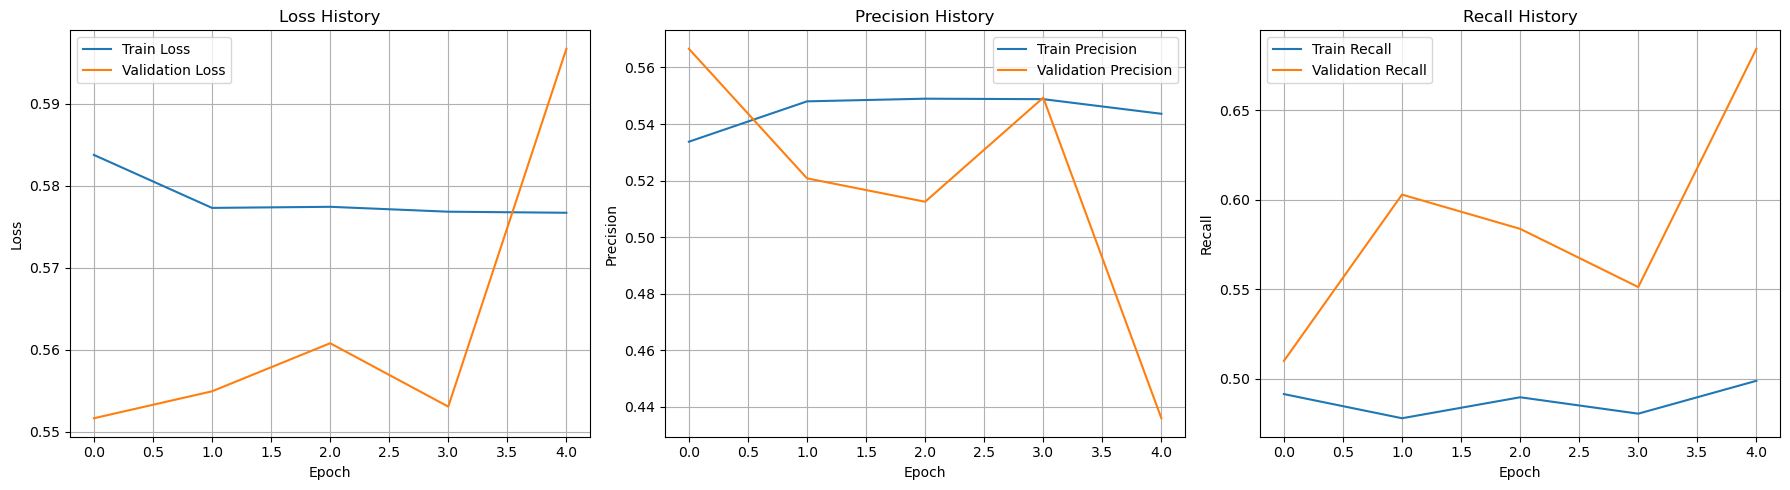

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(18, 5))
    
    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Precision
    plt.subplot(1, 3, 2)
    plt.plot(history.history.get('precision', []), label='Train Precision')
    plt.plot(history.history.get('val_precision', []), label='Validation Precision')
    plt.title('Precision History')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    
    # Plot Recall
    plt.subplot(1, 3, 3)
    plt.plot(history.history.get('recall', []), label='Train Recall')
    plt.plot(history.history.get('val_recall', []), label='Validation Recall')
    plt.title('Recall History')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


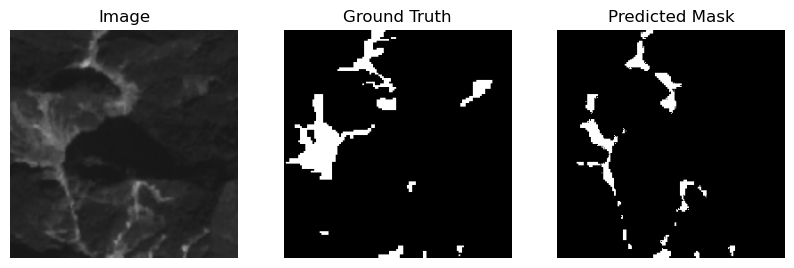

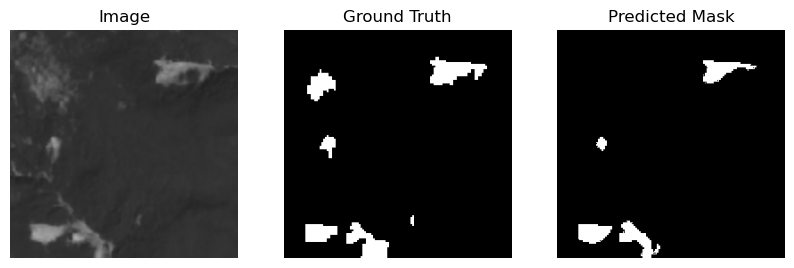

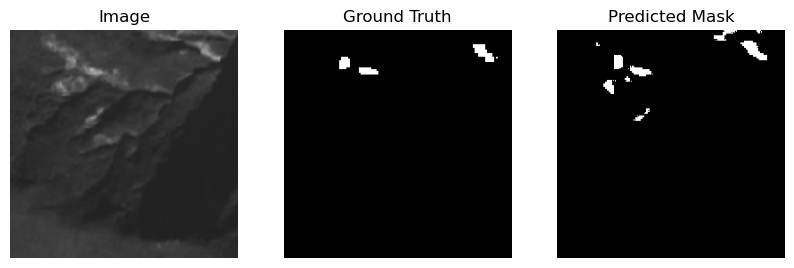

In [21]:
#Visualization of Predictions
for images, masks in val_dataset.take(1):
    preds = model.predict(images)
    preds = (preds > 0.5).astype(np.uint8)

    for i in range(min(3, images.shape[0])):
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1)
        plt.imshow(images[i].numpy())
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(masks[i,:,:,0].numpy(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(preds[i,:,:,0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step   
Accuracy : 0.9553
Precision: 0.5149
Recall   : 0.5934
F1 Score : 0.5513
ROC AUC  : 0.9550
Confusion Matrix:
 [[12101059   337321]
 [  245300   357984]]


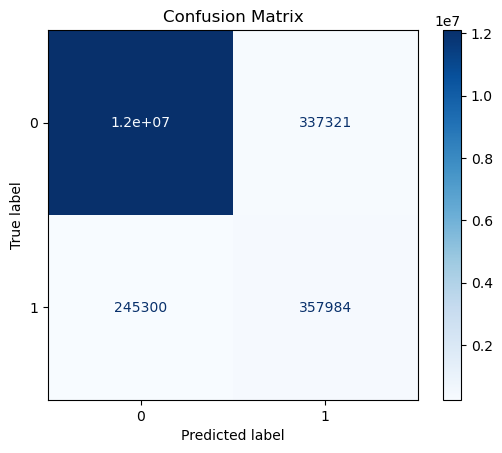

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# 1. Get predicted masks
y_pred_prob = model.predict(test_dataset)  # Probabilities
y_pred = (y_pred_prob >= 0.5).astype(int)  # Threshold at 0.5

# 2. Flatten ground truth and predictions
y_true = np.concatenate([m.numpy().flatten() for _, m in test_dataset], axis=0)
y_pred_flat = y_pred.flatten()

# 3. Compute metrics
accuracy  = accuracy_score(y_true, y_pred_flat)
precision = precision_score(y_true, y_pred_flat)
recall    = recall_score(y_true, y_pred_flat)
f1        = f1_score(y_true, y_pred_flat)
roc_auc   = roc_auc_score(y_true, y_pred_prob.flatten())

# 4. Confusion matrix
cm = confusion_matrix(y_true, y_pred_flat)

# 5. Display results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("Confusion Matrix:\n", cm)

# 6. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
